#Deep Learning Assignment 1

##Install Requirements

In [1]:
!pip install Kaggle

##Download the Dataset

In [2]:
#!/bin/bash
!kaggle datasets download puneet6060/intel-image-classification

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
100% 346M/346M [00:03<00:00, 132MB/s]
100% 346M/346M [00:03<00:00, 121MB/s]


In [3]:
!unzip /content/intel-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

##Create Dataset

In [4]:
import timm
from timm.data import create_dataset
from timm.data.transforms_factory import create_transform
train_dir = "/content/seg_train/seg_train"
test_dir="/content/seg_test/seg_test"

data_train = create_dataset('', train_dir,  split='train', transform=create_transform(input_size=224, is_training=True, auto_augment='rand-m9-mstd0.5'))
data_test = create_dataset('', test_dir,  split='test', transform=create_transform(input_size=224, is_training=False))

len(data_train), len(data_test)

(14034, 3000)

##Class Mapping

In [5]:
import os
classes = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
classes.sort()
classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [6]:
nclasses = len(classes)
nclasses

6

##Create Loaders

In [7]:
from timm.data.loader import create_loader

try:
    # only works if gpu present on machine
    train_dataloader = create_loader(data_train, input_size=224, batch_size=32, is_training=True)
    test_dataloader = create_loader(data_test, input_size=224, batch_size=32, is_training=False)
except:
    train_dataloader = create_loader(data_train, input_size=224, batch_size=32, is_training=True,use_prefetcher=False)
    test_dataloader = create_loader(data_test, input_size=224, batch_size=32, is_training=False,use_prefetcher=False)

Images

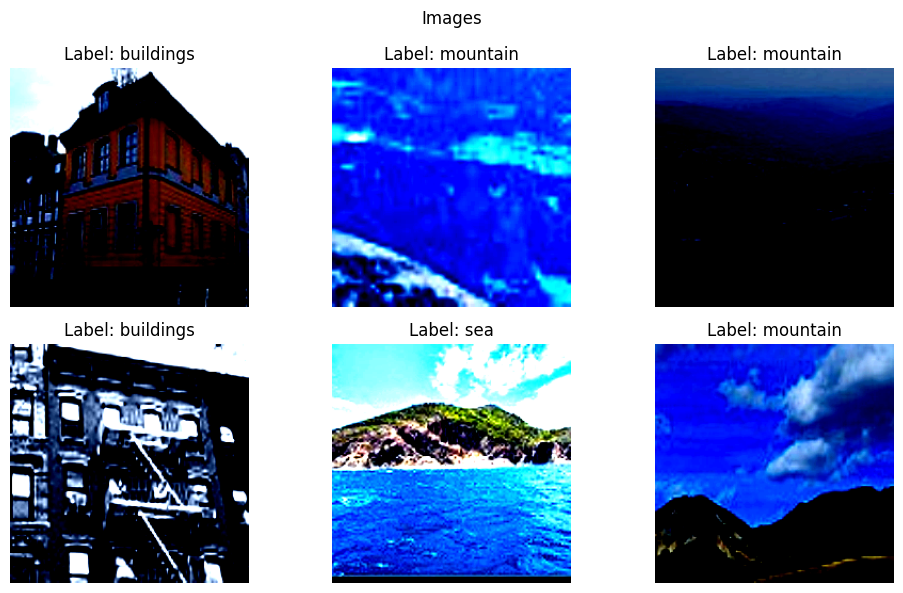

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
indices = np.random.choice(len(data_train), 8, replace=False)
images = []
labels = []
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
for idx in indices:
    img, label = data_train[idx]
    images.append(img)
    labels.append(classes[label])

unnormalize = transforms.Normalize(
    mean=[-m/s for m, s in zip(mean, std)],
    std=[1/s for s in std]
)



fig, axes = plt.subplots(2, 3, figsize=(10, 6))
fig.suptitle("Images")
for i, ax in enumerate(axes.flat):
    if isinstance(images[i], torch.Tensor):
        img = unnormalize(images[i])
        img = img.permute(1, 2, 0).numpy()
        img = images[i].permute(1, 2, 0).numpy()  # Convert from CxHxW to HxWxC
    else:
        img = images[i]
    ax.imshow(img)
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()



#Models

##Model 1: Resnest26d

In [8]:
import timm
import torch
m1 = timm.create_model('resnest26d', pretrained=True)
m1.eval() #The returned PyTorch model is set to train mode by default
x = torch.randn(1, 3, 224, 224)
features = m1.forward_features(x)
print(features.shape)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/68.4M [00:00<?, ?B/s]

torch.Size([1, 2048, 7, 7])


In [10]:
if torch.cuda.is_available():
    device = torch.device('cuda')  # CUDA GPU
elif torch.backends.mps.is_available():
    device = torch.device('mps') #Apple GPU
else:
    device = torch.device("cpu")

##Modified pooling using 'avgmax'

In [11]:
print(f'Original pooling: {m1.global_pool}')
print(f'Original classifier: {m1.get_classifier()}')
print('--------------------')

m1.reset_classifier(nclasses, 'avgmax')

print(f'Modified pooling: {m1.global_pool}')
print(f'Modified classifier: {m1.get_classifier()}')

Original pooling: SelectAdaptivePool2d(pool_type=avg, flatten=Flatten(start_dim=1, end_dim=-1))
Original classifier: Linear(in_features=2048, out_features=1000, bias=True)
--------------------
Modified pooling: SelectAdaptivePool2d(pool_type=avgmax, flatten=Flatten(start_dim=1, end_dim=-1))
Modified classifier: Linear(in_features=2048, out_features=6, bias=True)


##Optimize using SGD

In [12]:
from torch import nn
from timm.optim import create_optimizer_v2
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = create_optimizer_v2(m1, opt='sgd', lr=0.01, momentum=0.8); optimizer, type(optimizer)

(SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     fused: None
     lr: 0.01
     maximize: False
     momentum: 0.8
     nesterov: True
     weight_decay: 0.0
 ),
 torch.optim.sgd.SGD)

##Model training

In [9]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [13]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = train(model=m1,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5673 | train_acc: 0.4348 | test_loss: 0.9731 | test_acc: 0.5889
Epoch: 2 | train_loss: 0.8616 | train_acc: 0.6615 | test_loss: 0.5301 | test_acc: 0.8102
Epoch: 3 | train_loss: 0.7118 | train_acc: 0.7310 | test_loss: 0.4684 | test_acc: 0.8205
Epoch: 4 | train_loss: 0.6271 | train_acc: 0.7633 | test_loss: 0.3645 | test_acc: 0.8678
Epoch: 5 | train_loss: 0.5597 | train_acc: 0.7932 | test_loss: 0.3432 | test_acc: 0.8831
[INFO] Total training time: 693.815 seconds


##Loss & Accuracy curves

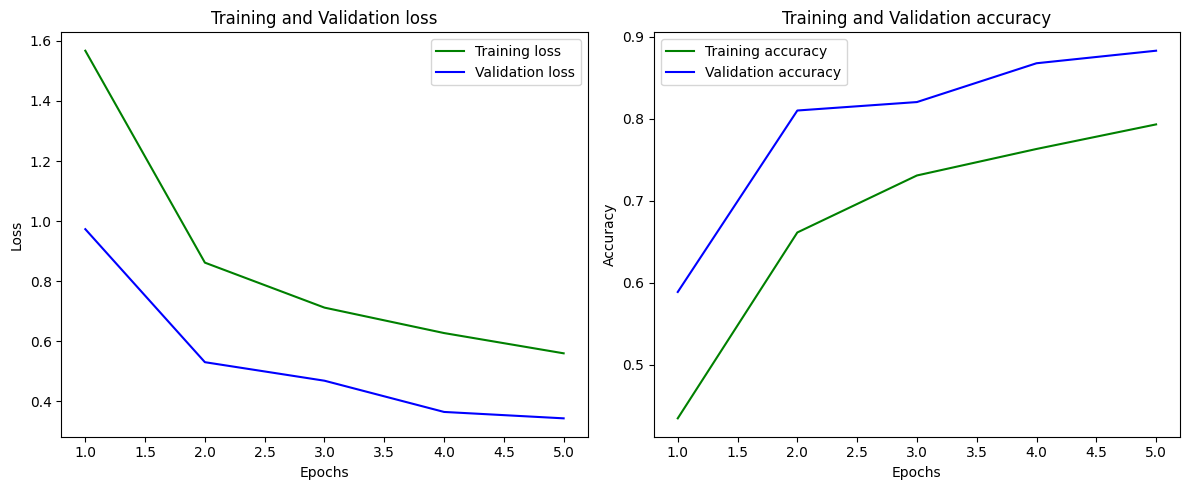

In [14]:
import matplotlib.pyplot as plt

epochs = [1,2,3,4,5]

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation loss
ax1.plot(epochs, results["train_loss"], 'g', label='Training loss')
ax1.plot(epochs, results["test_loss"], 'b', label='Validation loss')
ax1.set_title('Training and Validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot training and validation accuracy
ax2.plot(epochs, results["train_acc"], 'g', label='Training accuracy')
ax2.plot(epochs, results["test_acc"], 'b', label='Validation accuracy')
ax2.set_title('Training and Validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

##Model 2: Resnest26d

In [15]:
import timm
import torch
m = timm.create_model('resnest26d', pretrained=True)
m.eval() #The returned PyTorch model is set to train mode by default
x = torch.randn(1, 3, 224, 224)
features = m.forward_features(x)
print(features.shape)

torch.Size([1, 2048, 7, 7])


##Modified pooling using 'max'

In [16]:
print(f'Original pooling: {m.global_pool}')
print(f'Original classifier: {m.get_classifier()}')
print('--------------------')

m.reset_classifier(nclasses, 'max')

print(f'Modified pooling: {m.global_pool}')
print(f'Modified classifier: {m.get_classifier()}')

Original pooling: SelectAdaptivePool2d(pool_type=avg, flatten=Flatten(start_dim=1, end_dim=-1))
Original classifier: Linear(in_features=2048, out_features=1000, bias=True)
--------------------
Modified pooling: SelectAdaptivePool2d(pool_type=max, flatten=Flatten(start_dim=1, end_dim=-1))
Modified classifier: Linear(in_features=2048, out_features=6, bias=True)


##Optimize using Adam

In [17]:
from torch import nn
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)

## Model training

In [18]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results1 = train(model=m,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8805 | train_acc: 0.7280 | test_loss: 0.6152 | test_acc: 0.7873
Epoch: 2 | train_loss: 0.5960 | train_acc: 0.7916 | test_loss: 0.3578 | test_acc: 0.8732
Epoch: 3 | train_loss: 0.5186 | train_acc: 0.8144 | test_loss: 0.3016 | test_acc: 0.8890
Epoch: 4 | train_loss: 0.4662 | train_acc: 0.8331 | test_loss: 0.3681 | test_acc: 0.8736
Epoch: 5 | train_loss: 0.4433 | train_acc: 0.8410 | test_loss: 0.3145 | test_acc: 0.8943
[INFO] Total training time: 701.425 seconds


##Loss & Accuracy curves

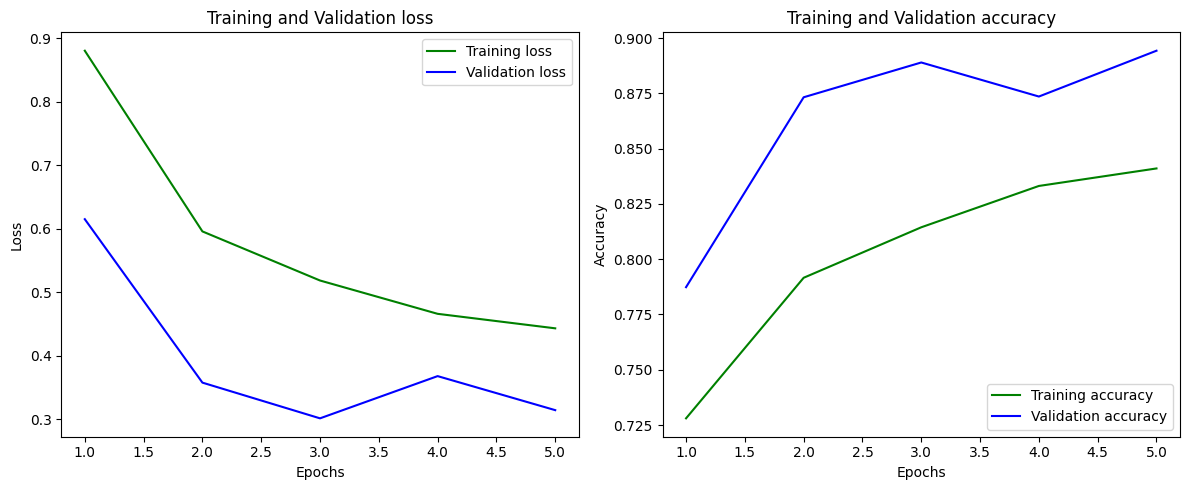

In [19]:
import matplotlib.pyplot as plt

epochs = [1,2,3,4,5]

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation loss
ax1.plot(epochs, results1["train_loss"], 'g', label='Training loss')
ax1.plot(epochs, results1["test_loss"], 'b', label='Validation loss')
ax1.set_title('Training and Validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot training and validation accuracy
ax2.plot(epochs, results1["train_acc"], 'g', label='Training accuracy')
ax2.plot(epochs, results1["test_acc"], 'b', label='Validation accuracy')
ax2.set_title('Training and Validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

##Export Using ONNX

In [20]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 95.2 MB/s eta 0:00:00


In [21]:
!pip install onnxruntime-gpu onnx onnxconverter_common==1.8.1 pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.5/291.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.6 MB/s eta 0:00:00


In [22]:
import numpy as np    # we're going to use numpy to process input and output data
import onnxruntime    # to inference ONNX models, we use the ONNX Runtime
import onnx
from onnx import numpy_helper
import urllib.request
import json
import time

# display images in notebook
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

%matplotlib inline

In [23]:
img, label = data_test[0]

In [24]:
img.shape

torch.Size([3, 224, 224])

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
m = m.to(device)

In [27]:
x = torch.randn(2, 3, 224, 224, requires_grad=True).to(device)

In [28]:
#x = torch.randn(2, 3, 224, 224, requires_grad=True)
torch_out = m(x)

# Export the model
torch.onnx.export(m,                                       # model being run
                  x,                                           # model input (or a tuple for multiple inputs)
                  "resnet26dsegclass.onnx",                            # where to save the model (can be a file or file-like object)
                  export_params=True,                          # store the trained parameter weights inside the model file
                  opset_version=10,                            # the ONNX version to export the model to
                  do_constant_folding=True,                    # whether to execute constant folding for optimization
                  input_names = ['input'],                     # the model's input names
                  output_names = ['output'],                   # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},  # variable length axes
                                'output': {0 : 'batch_size'}})

In [30]:
import onnx

onnx_model = onnx.load("resnet26dsegclass.onnx")
onnx.checker.check_model(onnx_model)

In [32]:
traced_model=torch.jit.trace(m, torch.rand(8,3,224,224).to(device))

In [33]:
traced_output=traced_model(torch.rand(8,3,224,224).to(device))
traced_output.shape

torch.Size([8, 6])

In [34]:
# Run the model on the backend
session = onnxruntime.InferenceSession('resnet26dsegclass.onnx', None)

# get the name of the first input of the model
input_name = session.get_inputs()[0].name

print('Input Name:', input_name)

Input Name: input


In [35]:
def load_labels(path):
    with open(path) as f:
        data = json.load(f)
    return np.asarray(data)

def preprocess(input_data):
    # convert the input data into the float32 input
    img_data = input_data.astype('float32')

    #normalize
    mean_vec = np.array([0.485, 0.456, 0.406])
    stddev_vec = np.array([0.229, 0.224, 0.225])
    norm_img_data = np.zeros(img_data.shape).astype('float32')
    for i in range(img_data.shape[0]):
        norm_img_data[i,:,:] = (img_data[i,:,:]/255 - mean_vec[i]) / stddev_vec[i]

    #add batch channel
    norm_img_data = norm_img_data.reshape(1, 3, 224, 224).astype('float32')
    return norm_img_data

def softmax(x):
    x = x.reshape(-1)
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def postprocess(result):
    return softmax(np.array(result)).tolist()

In [36]:
filename = '/content/seg_test/seg_test/buildings/20083.jpg'
input_image = Image.open(filename)

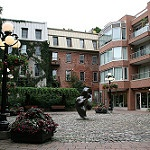

In [37]:
input_image

In [38]:
newsize = (224, 224)
input_image = input_image.resize(newsize)
# Shows the image in image viewer
input_image.show()

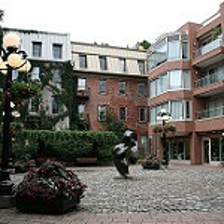

In [39]:
input_image

In [41]:
m = m.to(device)
x = torch.randn(8, 3, 224, 224, requires_grad=True).to(device)

traced_model = torch.jit.trace(m, x)

/usr/local/lib/python3.10/dist-packages/torch/jit/_trace.py:166: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  if a.grad is not None:


Image size:  (224, 224)


(3, 224, 224)

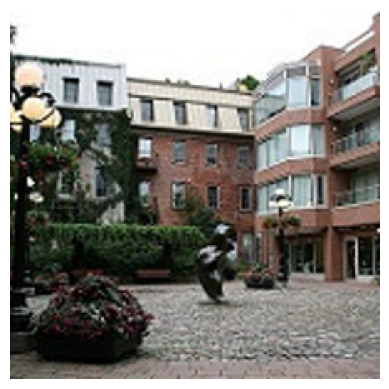

In [42]:
labels = classes

print("Image size: ", input_image.size)
plt.axis('off')
display_image = plt.imshow(input_image)
image_data = np.array(input_image).transpose(2, 0, 1)
image_data.shape

In [43]:
input_data = preprocess(image_data)

In [44]:
input_data.shape

(1, 3, 224, 224)

In [45]:
start = time.time()
raw_result = session.run([], {input_name: input_data})
end = time.time()
res = postprocess(raw_result)

Final top prediction is: buildings
Inference time: 89.98 ms
============ Top 5 labels are: ============================
['buildings', 'street', 'sea', 'forest', 'mountain']


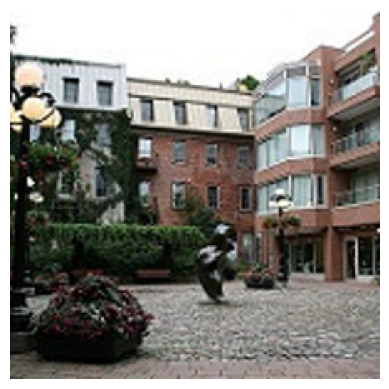

In [46]:
inference_time = np.round((end - start) * 1000, 2)
idx = np.argmax(res)

print('========================================')
print('Final top prediction is: ' + labels[idx])
print('========================================')

print('========================================')
print('Inference time: ' + str(inference_time) + " ms")
print('========================================')

sort_idx = np.flip(np.squeeze(np.argsort(res)))
print('============ Top 5 labels are: ============================')
print([labels[i] for i in sort_idx[:5].tolist()])
print('===========================================================')

plt.axis('off')
display_image = plt.imshow(input_image)

In [47]:
type(traced_model)

torch.jit._trace.TopLevelTracedModule

In [48]:
traced_model(torch.rand(8, 3, 224, 224).to(device)).shape

torch.Size([8, 6])

In [50]:
filename = '/content/seg_test/seg_test/mountain/20116.jpg' # change to your filename
from torchvision import models, datasets, transforms as T
import torch
from PIL import Image
import numpy as np

input_image = Image.open(filename)
preprocess = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)
print("GPU Availability: ", torch.cuda.is_available())
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')

GPU Availability:  True


##Inference Optimization

In [51]:
# Inference with ONNX Runtime
import onnxruntime
from onnx import numpy_helper
import time

session_fp32 = onnxruntime.InferenceSession("resnet26dsegclass.onnx", providers=['CPUExecutionProvider'])
# session_fp32 = onnxruntime.InferenceSession("resnet50.onnx", providers=['CUDAExecutionProvider'])
# session_fp32 = onnxruntime.InferenceSession("resnet50.onnx", providers=['OpenVINOExecutionProvider'])

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


def run_sample(session, categories, inputs):
    latency = []
    start = time.time()
    input_arr = inputs.cpu().detach().numpy()
    ort_outputs = session.run([], {'input':input_arr})[0]
    latency.append(time.time() - start)
    output = ort_outputs.flatten()
    output = softmax(output) # this is optional
    top5_catid = np.argsort(-output)[:5]
    for catid in top5_catid:
        print(categories[catid], output[catid])
    return ort_outputs, latency

ort_output, latency = run_sample(session_fp32, classes, input_batch)
print("ONNX Runtime CPU/GPU/OpenVINO Inference time = {} ms".format(format(sum(latency) * 1000 / len(latency), '.2f')))

mountain 0.7427213
glacier 0.24179192
sea 0.007969232
buildings 0.00437777
street 0.0024547195
ONNX Runtime CPU/GPU/OpenVINO Inference time = 83.44 ms


In [52]:
input_batch.shape

torch.Size([1, 3, 224, 224])